In [11]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import os

In [12]:
absolute_path = os.path.join(os.getcwd(), '/mnist')

In [13]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = MNIST(os.getcwd(), transform=transform, download=True)
test_dataset  = MNIST(os.getcwd(), transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

one_image_loader = DataLoader(train_dataset, batch_size=1, shuffle=True) # For visualising

In [14]:
def plot_image(tensor):

    if tensor.shape[0] == 1:
        tensor = tensor.squeeze(0)

    image = tensor.numpy()


    plt.imshow(image, cmap='gray' if tensor.ndim == 2 else None)
    plt.axis('off')
    plt.show()

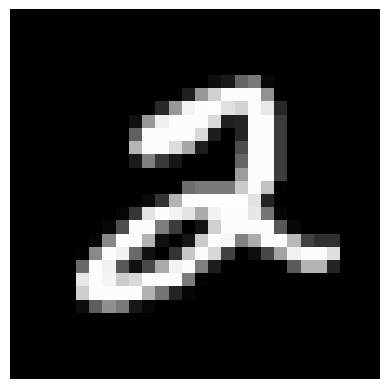

In [15]:
plot_image(train_dataset[5][0])

# Autoencoder:

In [37]:
class AutoEncodingVariationalBayes(nn.Module):
    def __init__(self, input_dim, hidden_layers, inter_dim = 256):
        super(AutoEncodingVariationalBayes, self).__init__()

        self.input_dim = input_dim
        self.hidden_layers = hidden_layers
        self.inter_dim = inter_dim

        # Appendix C.2, switch-out Z with X as described ============================
        self.encoder_mlp = nn.Sequential(
            nn.Linear(self.input_dim, inter_dim), # Here are the weights W_3 that make up phi
            nn.Tanh(),
        )

        self.latent_u_prediction_head = nn.Linear(inter_dim, hidden_layers) # Here are the weights W_4 that make up phi
        self.latent_variance_prediction_head = nn.Linear(inter_dim, hidden_layers) # Here are the weights W_5 that make up phi
        # ===========================================================================

        # Appendix C.2, implemented exactly in this way ---------------------------------
        self.decoder_mlp = nn.Sequential(
            nn.Linear(hidden_layers, inter_dim), # Here are the weights W_3 that make up theta
            nn.Tanh()
        )

        self.output_u_prediction_head = nn.Linear(inter_dim, input_dim) # Here are the weights W_4 that make up theta
        self.output_variance_prediction_head = nn.Linear(inter_dim, input_dim) # Here are the weights W_5 that make up theta
        # ---------------------------------------------------------------------------------

    def encoder_forward(self, X):
        h = self.encoder_mlp(X)
        latent_u = self.latent_u_prediction_head(h)
        latent_variance = self.latent_variance_prediction_head(h)

        latent_logvariance = torch.log(latent_variance)

        return latent_u, latent_logvariance # These are the estimates of parameters for q_phi(Z|X) ~ N(latent_u, latent_variance)

    def decoder_forward(self, latent_u, latent_logvariance, sampled_error_e = 0):
        Z = latent_u + torch.sqrt(torch.exp(latent_logvariance))*sampled_error_e # Latent variables Z
        # We sample from prior only during training, so during prediction Z = latent_u

        h = self.decoder_mlp(Z)
        output_u = self.output_u_prediction_head(h) # This is the main prediction of X_hat
        output_variance = self.output_variance_prediction_head(h) # Not needed to reconstruct, but gives us an estimate of the variance

        output_logvariance = torch.log(output_variance)

        return output_u, output_logvariance # These are the estimates of parameters for p_theta(X|Z) ~ N(output_u, output_variance)

    def sample_from_prior(self):
        samples = torch.randn(self.hidden_layers) # This is a prior p(Z) ~ N(0,1)
        return samples

    def forward(self, X):
        latent_u, latent_logvariance = self.encoder_forward(X)
        sampled_error_e = self.sample_from_prior()
        X_hat, logvariance = self.decoder_forward(latent_u, latent_logvariance, sampled_error_e)
        return X_hat, logvariance, latent_u, latent_logvariance

In [38]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

# Testing whether the VAE works:

In [39]:
VAE = AutoEncodingVariationalBayes(784, 2)
VAE.apply(init_weights)


single_image, _ = next(iter(one_image_loader))
single_image = single_image.view(single_image.size(0),-1)

VAE(single_image)[0]

tensor([[-6.4504e-02, -9.2389e-02, -8.9336e-02, -4.8080e-02, -7.8155e-02,
          1.3013e-02, -1.7102e-02, -1.3335e-02, -1.3939e-01,  2.6205e-03,
         -3.1015e-02, -3.4672e-02, -2.1834e-03,  3.3580e-03,  2.3290e-02,
          2.0854e-02,  1.1169e-01, -1.4209e-01,  5.0511e-02, -3.3842e-02,
         -6.9132e-03, -4.4042e-02, -1.2945e-01,  7.0176e-02,  4.2429e-02,
         -9.3620e-02,  3.1199e-03,  4.2646e-02, -1.2024e-01, -6.6701e-02,
         -1.3897e-02,  3.2461e-02, -2.9942e-02,  5.7409e-02,  1.7352e-02,
         -7.6230e-03,  8.3385e-03,  1.0128e-01,  4.6744e-02, -1.8123e-02,
          3.4477e-02,  4.4814e-02,  1.8115e-01, -5.3046e-02,  4.9229e-02,
          9.8609e-02, -1.4016e-02,  2.5415e-02, -5.8195e-02,  2.9485e-02,
         -9.2156e-02,  5.2629e-02,  3.2637e-02,  6.8712e-02,  2.7292e-02,
         -6.2049e-02,  1.5366e-02, -9.6113e-03,  1.6409e-02, -3.9217e-02,
         -6.7798e-03,  5.6919e-02, -4.7586e-03,  6.0651e-02,  1.6275e-02,
          1.2315e-01,  9.4532e-03, -8.

# Loss function:

In [40]:
def gaussian_log_likelihood(X, X_hat, logvar):
    reconstruction_loss = torch.sum(-0.5 * (torch.log(2 * torch.pi) + logvar + (X - X_hat) ** 2 / torch.exp(logvar)))
    return reconstruction_loss / X.size(0)  # Normalize by batch size

In [41]:
def kullback_leiber_divergence(latent_u, latent_logvar):
    kl_div = -0.5 * torch.sum(1 + latent_logvar - latent_u.pow(2) - latent_logvar.exp())
    return kl_div